<a href="https://colab.research.google.com/github/CoryLaidlaw/fastai_tutorial_notes/blob/main/Chest_X_Ray_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!conda install pyarrow
!pip install pydicom kornia opencv-python scikit-image nbdev

/bin/bash: line 1: conda: command not found


In [4]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

# DICOM Data

## Get Data

using SIIM-ACR Pneumothorax Segmentation dataset.

In [5]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

Images are DICOM (**D**igital **I**maging and **CO**munications in **M**edicine) which is the defacto standard that establishes rules that allow medical images and associated information to be exchanged between imaging equipment.

DICOM files typically have.dcm extension and stores data in seperate tags, such as patient and image/pixel data. Extracting data from tags gives access to information regarding demographics, study parameters, ect.

16-bit DICOM images have values from -32768 to 32768, while 8-bit greyscale images store values from 0 to 255. DICOM value ranges correlate to the Hounsfield Scale (a quantitative scale for describing radiodensity)

## Plotting Data

Using get_dicom_files

In [6]:
items = get_dicom_files(pneumothorax_source/f"train/")

Using RandomSplitter to split items into a train and validation list

In [7]:
trn, val = RandomSplitter()(items)

Pydicom is a python package for parsing DICOM files, making it easier to access the header and converting raw pixel_data into pythonic structures.

fastai.medical.imaging uses pydicom.dcmread to load DICOM

In [8]:
patient = 7
xray_sample = items[patient].dcmread()

Viewing header

In [9]:
xray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.32070.1517875158.272331
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.32070.1517875158.272331
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Key pointers:
* Pixel Data (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
* Photometric Interpretation (0028, 0004) - also known as color space. In this case it is MONOCHROME2 where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was MONOCHROME then the low values=bright and high values=dark info.
* Samples per Pixel (0028, 0002) - This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example
* Bits Stored (0028 0101) - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between 0 and 255
* Pixel Represenation(0028 0103) - can either be unsigned(0) or signed(1)
* Lossy Image Compression (0028 2110) - 00 image has not been subjected to lossy compression. 01 image has been subjected to lossy compression.
* Lossy Image Compression Method (0028 2114) - states the type of lossy compression used (in this case ISO_10918_1 represents JPEG Lossy Compression)
* Pixel Data (7fe0, 0010) - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.

Raw PixelData

In [11]:
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0B\x7f\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x00\x01\x02\x07\x08\t\xff\xc4\x00R\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x07\x03\x02\x03\x04\x02\x13\x01\x02\x11\x00\x03!\x04\x121\x05A\x13"Qa\x06q\x81\x142\x91\xa1\xf0\x07#B\xb1\xc1\xd1\xe1\x15R\xf13b\x08\x16$Ccr\xb2%&4Ds\x82'

PixelData converted to a numpy array

In [12]:
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[100,  81,  65, ..., 174, 183, 120],
        [ 81,  63,  49, ..., 168, 177, 113],
        [ 61,  44,  33, ..., 165, 173, 108],
        ...,
        [  0,   0,   0, ..., 111, 130,  86],
        [  0,   0,   0, ..., 112, 131,  87],
        [  0,   0,   0, ..., 115, 133,  90]], dtype=uint8),
 (1024, 1024))

PixelData Image

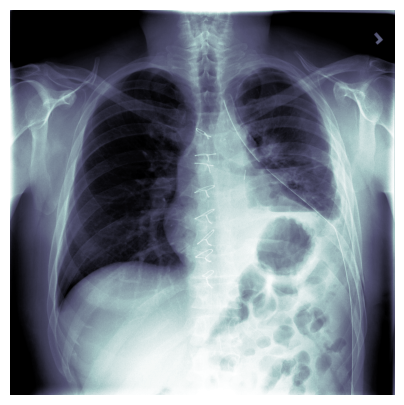

In [13]:
xray_sample.show()

Creating a dataframe with all the tag info as columns using from_dicoms

In [14]:
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2667.1517875173.957745,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000107.dcm,0,255,114.464372,57.746993,0.276343
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.524.1517875163.298894,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000153.dcm,0,210,112.751471,52.650028,0.224548
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.556.1517875163.421242,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000126.dcm,0,255,121.391561,51.112038,0.169630
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.13447.1517875245.367852,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000139.dcm,0,255,126.244518,67.579221,0.224724
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2173.1517875171.480769,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000187.dcm,0,237,112.279405,66.835665,0.271656


Loading labels

In [15]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


## DataBlock & DataLoader

Using DataBlock to prepare data fior training

In [16]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])

dls = pneumothorax.dataloaders(df.values, num_workers=0)

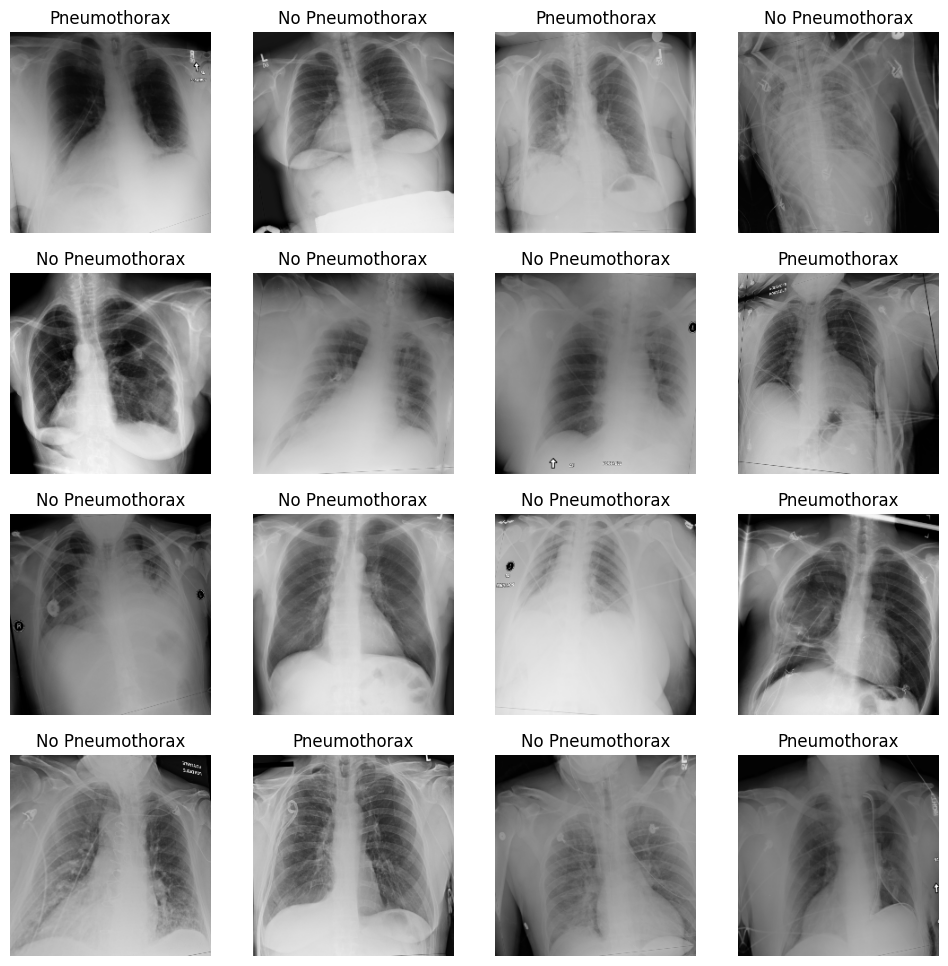

In [17]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

# Training

Using vison_learner

In [18]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s]


FastAI will try to choose the best loss and optimizer when not selected. The loss function can be checked.

In [19]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

The optimizer function can be checked

In [20]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

Finding LR

SuggestedLRs(valley=0.0014454397605732083)

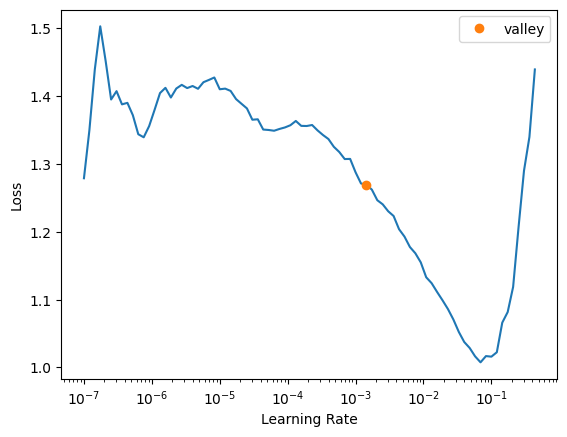

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.135979,1.315077,0.440000,00:04


In [23]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('Pneumothorax', tensor(1), tensor([0.3177, 0.6823]))

Predict return tuple (class, class tensor, probabilities of each class)

In [24]:
tta = learn.tta(use_max=True)

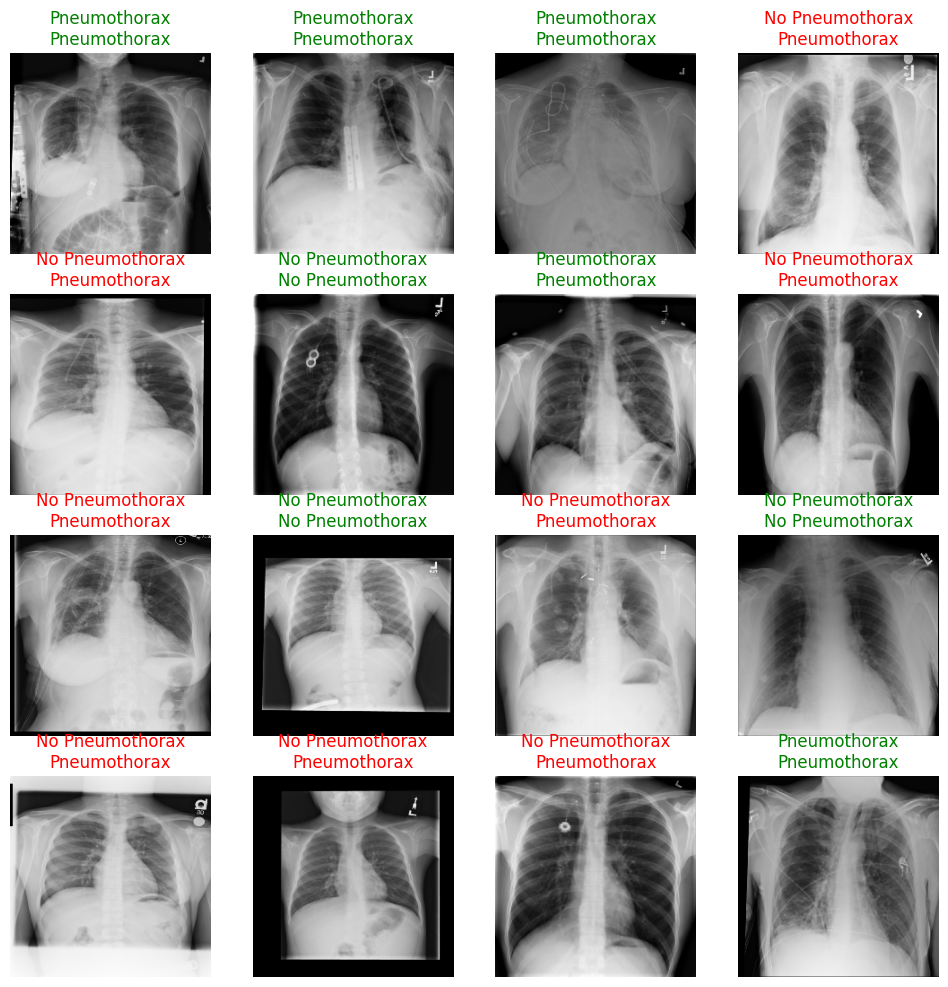

In [25]:
learn.show_results(max_n=16)

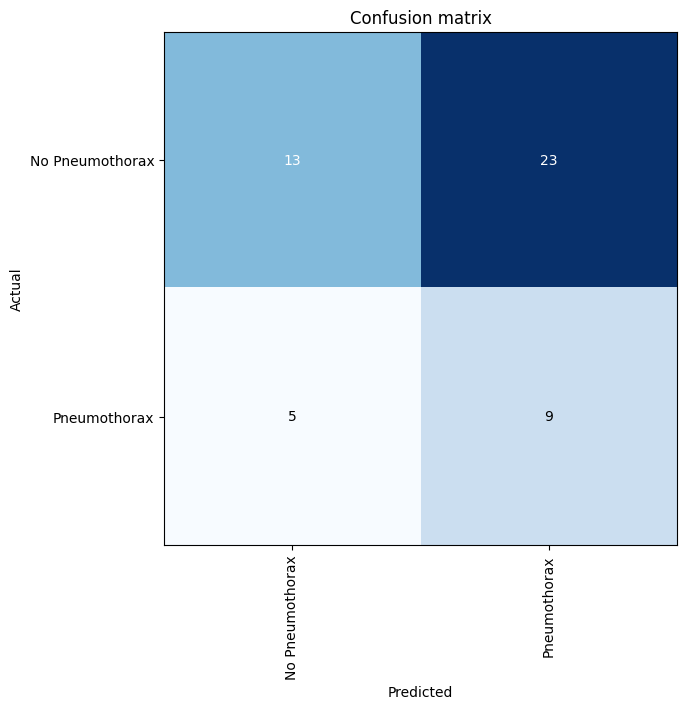

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))